In [3]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [4]:

# 1️⃣ 读取数据
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")  # 读取训练数据集
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")    # 读取测试数据集

# 2️⃣ 分离特征和标签
y_train = train["label"].values  # 提取标签 (0-9)
X_train = train.drop("label", axis=1).values  # 提取像素数据
X_test = test.values  # 测试集没有标签，直接取所有数据

# 3️⃣ 归一化数据
X_train = X_train / 255.0  # 归一化到 [0,1]，有助于模型训练
X_test = X_test / 255.0  # 同样归一化测试集

# 4️⃣ 重塑数据格式 (Reshape)
X_train = X_train.reshape(-1, 28, 28, 1)  # 变成 CNN 需要的格式 (n,28,28,1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 5️⃣ One-hot 编码标签
y_train = to_categorical(y_train, num_classes=10)  # 把 0-9 转换为 10 维向量


In [5]:
# 6️⃣ 拆分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# 90% 训练，10% 用于验证，防止过拟合

# 7️⃣ 定义数据增强 (Data Augmentation)
datagen = ImageDataGenerator(
    rotation_range=10,    # 旋转 ±10 度
    zoom_range=0.1,       # 随机缩放 ±10%
    width_shift_range=0.1, # 水平平移 ±10%
    height_shift_range=0.1 # 垂直平移 ±10%
)
datagen.fit(X_train)  # 让数据增强器适配训练数据


In [6]:


# 8️⃣ 构建 CNN 模型
model = Sequential([

    # 第一层卷积层 + 批量归一化 + 池化
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(28, 28, 1)),  # 卷积核 3x3，32 个滤波器
    BatchNormalization(),  # 归一化，提高稳定性
    Conv2D(32, (3,3), activation="relu", padding="same"),  # 第二个卷积层
    MaxPooling2D(2,2),  # 2x2 池化，减少尺寸
    Dropout(0.25),  # 随机丢弃 25% 的神经元，防止过拟合

    # 第二层卷积层
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # 第三层卷积层
    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(128, (3,3), activation="relu", padding="same"),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # 展平成全连接层
    Flatten(),
    Dense(256, activation="relu"),  # 全连接层 256 神经元
    Dropout(0.5),  # 丢弃 50%，防止过拟合
    Dense(10, activation="softmax")  # 输出层，10 类（0-9），使用 softmax 归一化
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:

# 9️⃣ 编译模型
model.compile(optimizer=Adam(learning_rate=0.001),  # Adam 优化器，学习率 0.001
              loss="categorical_crossentropy",  # 交叉熵损失（适用于分类任务）
              metrics=["accuracy"])  # 监控准确率

# 🔟 训练模型（使用数据增强）
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),  # 用增强数据训练
                    epochs=20,  # 训练 20 轮
                    validation_data=(X_val, y_val))  # 验证数据集


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.6680 - loss: 1.0529 - val_accuracy: 0.9698 - val_loss: 0.0957
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9554 - loss: 0.1556 - val_accuracy: 0.9869 - val_loss: 0.0437
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9722 - loss: 0.1013 - val_accuracy: 0.9838 - val_loss: 0.0539
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9740 - loss: 0.0935 - val_accuracy: 0.9871 - val_loss: 0.0481
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9760 - loss: 0.0880 - val_accuracy: 0.9912 - val_loss: 0.0344
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9782 - loss: 0.0809 - val_accuracy: 0.9879 - val_loss: 0.0401
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9816 - loss: 0.0654 - val_accuracy: 0.9917 - val_loss: 0.0288
Epoch 8/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9831 - loss: 0.0624 - val_accurac

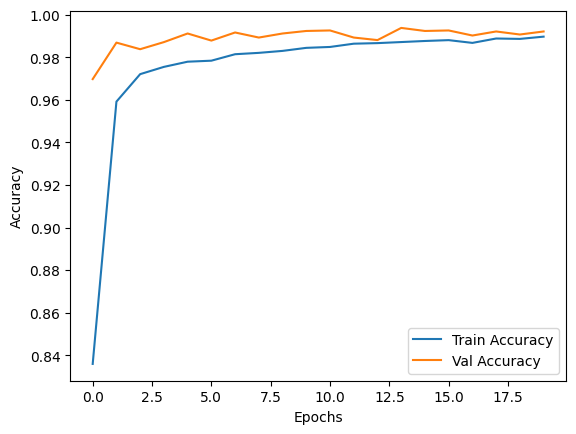

In [8]:

# 1️⃣1️⃣ 画出训练曲线
plt.plot(history.history["accuracy"], label="Train Accuracy")  # 训练准确率
plt.plot(history.history["val_accuracy"], label="Val Accuracy")  # 验证准确率
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:


# 1️⃣2️⃣ 计算验证集准确率
val_loss, val_acc = model.evaluate(X_val, y_val)  # 在验证集上评估
print(f"验证集准确率: {val_acc:.4f}")  # 输出最终准确率


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0323
验证集准确率: 0.9921


In [10]:

# 1️⃣3️⃣ 生成测试集预测
predictions = model.predict(X_test)  # 对测试集进行预测
predictions = np.argmax(predictions, axis=1)  # 取概率最高的类别

# 1️⃣4️⃣ 生成 Kaggle 提交文件
submission = pd.DataFrame({"ImageId": np.arange(1, len(predictions)+1), "Label": predictions})
submission.to_csv("submission.csv", index=False)  # 保存 CSV 文件
print("✅ 提交文件已生成: submission.csv")


875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
✅ 提交文件已生成: submission.csv
